In [1]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [2]:
# transformations
transform = T.Compose(
    [
        T.ToTensor(),
        T.RandomHorizontalFlip(p=0.5),
        T.Normalize(0.5, 0.5),
    ]
)

# import the data and simultaneously apply the transform
trainset = tv.datasets.FashionMNIST(
    root="../Datasets/", train=True, download=True, transform=transform
)
devtest = tv.datasets.FashionMNIST(
    root="../Datasets/", train=False, download=True, transform=transform
)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)  # a random permutation of indices
devset = Subset(devtest, randidx[:6000])  # Subset for devset
testset = Subset(devtest, randidx[6000:])  # Subset for test

# transform to dataloaders
batchsize = 32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True, generator=torch.Generator(device=device))
dev_loader = DataLoader(devset, batch_size=len(devset), generator=torch.Generator(device=device))
test_loader = DataLoader(testset, batch_size=len(testset), generator=torch.Generator(device=device))

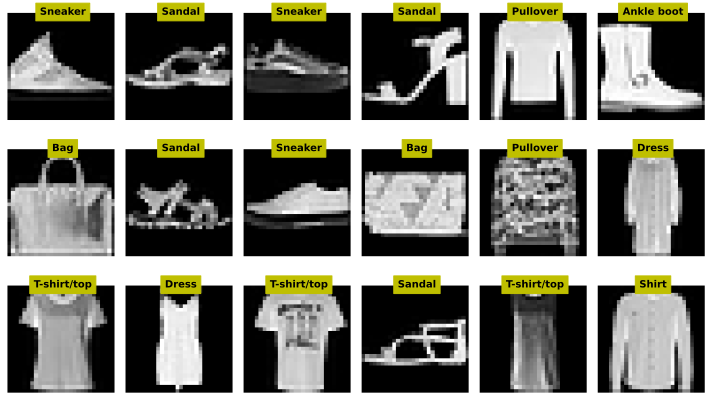

In [3]:
# inspect a few random images
X, y = next(iter(test_loader))

fig, axs = plt.subplots(3, 6, figsize=(10, 6))

for i, ax in enumerate(axs.flatten()):

    # extract that image
    pic = torch.squeeze(X.data[i])
    pic = pic / 2 + 0.5  # undo normalization

    # and its label
    label = trainset.classes[y[i]]

    # and show!
    ax.imshow(pic, cmap="gray")
    ax.text(
        14, 0, label, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

In [7]:
def createFMNISTAENet(print_toggle=False):
    class fmnistNet(nn.Module):

        def __init__(self, print_toggle):
            super().__init__()
            self.print = print_toggle

            # Encode Convolution layers
            self.encconv1 = nn.Conv2d(1, 16, 3, padding=1, stride = 2)
            self.encconv2 = nn.Conv2d(16, 32, 3, padding=1, stride=2)

            # Decode convolution layer
            self.decconv1 = nn.ConvTranspose2d(32, 16, 4, padding=1, stride=2)
            self.decconv2 = nn.ConvTranspose2d(16, 1, 4, padding=1, stride=2)

        def forward(self, x):

            if self.print: print(f'Input: {list(x.shape)}')
            
            # first encoder layer
            x = F.leaky_relu(self.encconv1(x))
            if self.print: print(f'First encoder layer: {list(x.shape)}')

            # second encoder layer
            x = F.leaky_relu(self.encconv2(x))
            if self.print: print(f'Second encoder layer: {list(x.shape)}')

            # first decoder layer
            x = F.leaky_relu(self.decconv1(x))
            if self.print: print(f'First decoder layer: {list(x.shape)}')

            # second decoder layer
            x = F.leaky_relu(self.decconv2(x))
            if self.print: print(f'Second decoder layer: {list(x.shape)}')

            return x  

    # Model instance
    net = fmnistNet(print_toggle)

    # Loss Function
    lossFun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossFun, optimizer

In [10]:
# test the model with one batch
tmpnet, lossfun, optimizer = createFMNISTAENet(True)

X, y = next(iter(train_loader))
X = X.to(device)
y = y.to(device)
yHat = tmpnet(X)

# check size of output
print("\nOutput size:")
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat, X)
print(" ")
print("Loss:")
print(loss)

Input: [32, 1, 28, 28]
First encoder layer: [32, 16, 14, 14]
Second encoder layer: [32, 32, 7, 7]
First decoder layer: [32, 16, 14, 14]
Second decoder layer: [32, 1, 28, 28]

Output size:
torch.Size([32, 1, 28, 28])
 
Loss:
tensor(0.7483, device='cuda:0', grad_fn=<MseLossBackward0>)


In [12]:
# a function that trains the model


def function2trainTheAEModel():

    # number of epochs
    numepochs = 10

    # create a new model
    net, lossfun, optimizer = createFMNISTAENet()

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    devLoss = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train()  # switch to train mode
        batchLoss = []
        for X, y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, X)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and accuracy from this batch
            batchLoss.append(loss.cpu().item())
        # end of batch loop...

        # and get average losses and accuracies across the batches
        trainLoss[epochi] = np.mean(batchLoss)

        #### test performance
        net.eval()  # switch to test mode
        X, y = next(iter(dev_loader))

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        with torch.no_grad():
            yHat = net(X)
            loss = lossfun(yHat, X)

        # and get average losses and accuracies across the batches
        devLoss[epochi] = loss.cpu().item()

    # end epochs

    # function output
    return trainLoss, devLoss, net

In [13]:
trainLoss, devLoss, aenet = function2trainTheAEModel()

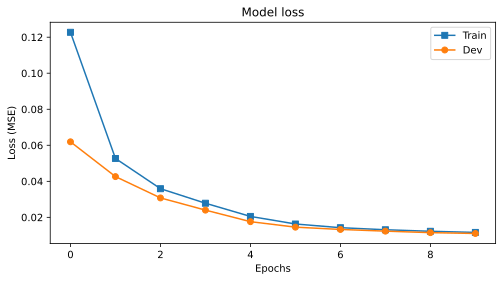

In [14]:
fig = plt.figure(figsize=(8, 4))

plt.plot(trainLoss.cpu(), "s-", label="Train")
plt.plot(devLoss.cpu(), "o-", label="Dev")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model loss")
plt.legend()

plt.show()

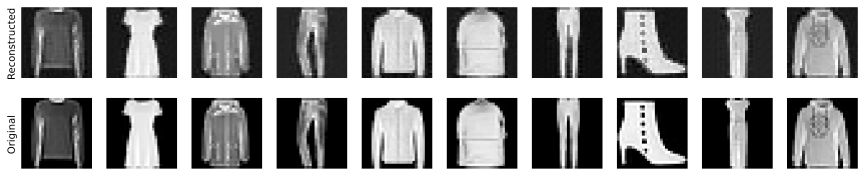

In [15]:
## show some random examples

# get some data
X, y = next(iter(dev_loader))

# forward pass and loss
aenet.cpu()
aenet.eval()  # switch to test mode
yHat = aenet(X)

fig, axs = plt.subplots(2, 10, figsize=(15, 3))

for i in range(10):
    pic = yHat[i, 0, :, :].detach()
    pic = pic / 2 + 0.5  # undo normalization
    axs[0, i].imshow(pic, cmap="gray")
    axs[0, i].axis("off")

    pic = X[i, 0, :, :].detach()
    pic = pic / 2 + 0.5  # undo normalization
    axs[1, i].imshow(pic, cmap="gray")
    axs[1, i].axis("off")

    if i == 0:
        axs[0, 0].text(-6, 14, "Reconstructed", rotation=90, va="center")
        axs[1, 0].text(-6, 14, "Original", rotation=90, va="center")


plt.show()

In [16]:
# Create the model which does the classification
def makeTheClassNet(printtoggle=False):

    class cnnnet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            # print toggle
            self.print = printtoggle

            ### -------------- encoder layers -------------- ###
            # first convolution layer
            self.encconv1 = nn.Conv2d(1, 16, 3, padding=1, stride=2)
            # output size: (28+2*1-3)/2 + 1 = 14

            # second convolution layer
            self.encconv2 = nn.Conv2d(16, 32, 3, padding=1, stride=2)
            # output size: (14+2*1-3)/2 + 1 = 7

            ### ------------- linear layers ------------- ###
            self.fc1 = nn.Linear(7 * 7 * 32, 50)
            self.fc2 = nn.Linear(50, 10)

        def forward(self, x):

            if self.print:
                print(f"Input: {list(x.shape)}")

            # first encoder layer
            x = F.leaky_relu(self.encconv1(x))
            if self.print:
                print(f"First encoder layer: {list(x.shape)}")

            # second encoder layer
            x = F.leaky_relu(self.encconv2(x))
            if self.print:
                print(f"Second encoder layer: {list(x.shape)}")

            # reshape to linear
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print:
                print(f"Post-convolution vectorized: {list(x.shape)}")

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            if self.print:
                print(f"First linear layer: {list(x.shape)}")

            x = F.leaky_relu(self.fc2(x))
            if self.print:
                print(f"Second linear layer: {list(x.shape)}")

            return x

    # create the model instance
    net = cnnnet(printtoggle)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [19]:
# test the model with one batch
tmpnet, lossfun, optimizer = makeTheClassNet(True)

X, y = next(iter(train_loader))
X = X.to(device)
y = y.to(device)
yHat = tmpnet(X)

# check size of output
print("\nOutput size:")
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat, y)
print(" ")
print("Loss:")
print(loss)

Input: [32, 1, 28, 28]
First encoder layer: [32, 16, 14, 14]
Second encoder layer: [32, 32, 7, 7]
Post-convolution vectorized: [32, 1568]
First linear layer: [32, 50]
Second linear layer: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.2995, device='cuda:0', grad_fn=<NllLossBackward0>)


In [21]:
# Now another function to train the classification model
def function2trainTheClassModel(net, lossfun, optimizer):

    # number of epochs
    numepochs = 10

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    devLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    devAcc = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train()  # switch to train mode
        batchLoss = []
        batchAcc = []

        for X, y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and accuracy from this batch
            batchLoss.append(loss.cpu().item())
            batchAcc.append(
                torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu().item()
            )
        # end of batch loop...

        # and get average losses and accuracies across the batches
        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi] = 100 * np.mean(batchAcc)

        #### test performance
        net.eval()  # switch to test mode
        X, y = next(iter(dev_loader))

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        with torch.no_grad():
            yHat = net(X)
            loss = lossfun(yHat, y)

        # and get average losses and accuracies across the batches
        devLoss[epochi] = loss.cpu().item()
        devAcc[epochi] = (
            100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu().item()
        )
    # end epochs

    # function output
    return trainLoss, devLoss, trainAcc, devAcc, net

In [ ]:
# train a new model from scratch (not pre-trained!)

# create a naive network
naivenet, lossfun, optimizer = makeTheClassNet()

# train it from scratch
trainLossNaive, devLossNaive, trainAccNaive, devAccNaive, naivenet = function2trainTheClassModel(naivenet, lossfun, optimizer)


## evaluate on the test set
naivenet.eval()  # switch to test mode
X, y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
    yHat = naivenet(X)
    loss = lossfun(yHat, y)

# loss and accuracy from this batch
testLossNaive = loss.item()
testAccNaive = 100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu().item()